In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy

# Set DeepXDE backend, we could use tensorflow, jax or paddle instead
os.environ['DDE_BACKEND'] = 'pytorch'

import deepxde as dde

# Increasing floating point precision
dde.config.set_default_float('float64')

# For experiments reproductibility
dde.config.set_random_seed(42)

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/home/gabriel/anaconda3/envs/modelagem/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Set the default float type to float64


## Verhulst model

The Verhulst model is defined as

\begin{eqnarray*}
\frac{d p(t)}{dt} &=& \left(a - b p(t)\right)p(t), \quad \forall \, t > t_0, \\
p(t_0) &=& p_0,
\end{eqnarray*}

whose exact solution is given by

\begin{equation*}
  p(t) = \frac{a p_0}{bp_0 + (a - bp_0)e^{-(t - t_0)}}.
\end{equation*}

We solve this problem in the time interval $[0, 10]$, so that $t_0 = 0$. Furthermore, we consider  

$$
a = 1.0, \quad b = 0.1, \quad p_0 \in \{0.1, 20\}.
$$

In [106]:
p0 = 0.1
a = 1.0
b = 0.1
t0, tf = 0, 5

In [107]:
def known_solution(t):
    return (a * p0) / (b * p0 + (a - b * p0) * np.exp(-(t - t0)))

Compiling model...
'compile' took 0.000096 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.10e-01, 1.00e-02]    [1.12e-01, 1.00e-02]    [1.12e+00]    
1000      [2.15e-03, 9.75e-04]    [1.77e-03, 9.75e-04]    [9.97e-01]    
2000      [2.14e-03, 9.55e-04]    [1.89e-03, 9.55e-04]    [9.94e-01]    
3000      [2.14e-03, 9.53e-04]    [1.89e-03, 9.53e-04]    [9.93e-01]    
4000      [2.14e-03, 9.53e-04]    [1.89e-03, 9.53e-04]    [9.93e-01]    
5000      [2.14e-03, 9.52e-04]    [1.89e-03, 9.52e-04]    [9.92e-01]    
6000      [2.13e-03, 9.51e-04]    [1.89e-03, 9.51e-04]    [9.91e-01]    
7000      [2.13e-03, 9.49e-04]    [1.89e-03, 9.49e-04]    [9.90e-01]    
8000      [2.13e-03, 9.53e-04]    [1.87e-03, 9.53e-04]    [9.90e-01]    
9000      [2.12e-03, 9.42e-04]    [1.87e-03, 9.42e-04]    [9.85e-01]    
10000     [2.06e-03, 8.95e-04]    [1.73e-03, 8.95e-04]    [9.67e-01]    
11000     [1.55e-03, 6.11e-04]    [1.14e-03, 6.11e-04]    [

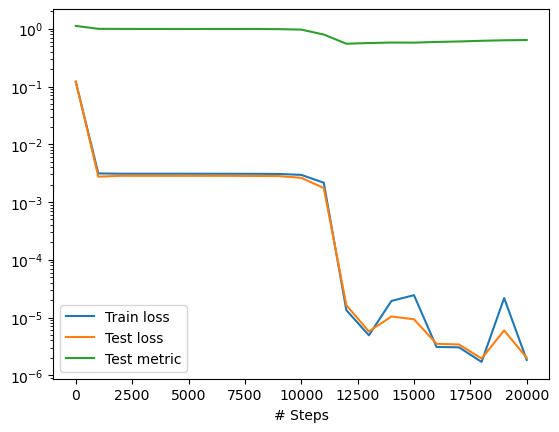

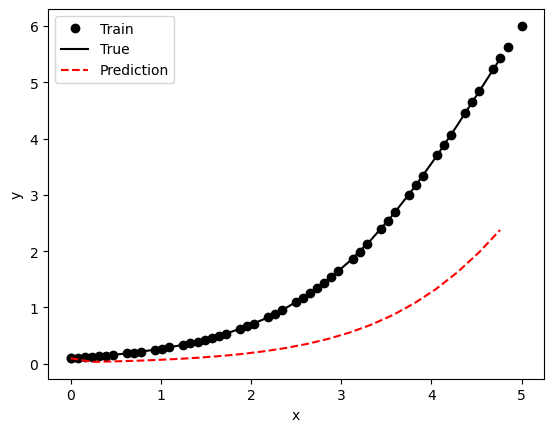

In [108]:

geom = dde.geometry.TimeDomain(t0, tf)

def ode(t, p):
    dp_dt = dde.grad.jacobian(p, t, i=0, j=0)
    return dp_dt - ((a - b * p) * p)

ic = dde.icbc.IC(
    geom, 
    lambda x: np.ones(x.shape) * p0, 
    lambda _, on_initial: on_initial,
    component=0)

n_domain = 50
n_bound = 2
n_test = 20

data = dde.data.PDE(geom, ode, ic, num_domain=n_domain, num_boundary=n_bound, solution=known_solution, num_test=n_test)

neurons = 50
layers = 3
layer_size = [1] + [neurons] * layers + [1]
activation = "tanh"
initializer = "Glorot uniform"
optimizer = "adam"
learning_rate = 0.001

net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)

model.compile(optimizer, lr=learning_rate, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, isplot=True, issave=False)


Compiling model...
'compile' took 0.000846 s

Training model...

Step      Train loss              Test loss               Test metric   
15000     [4.31e-06, 5.02e-09]    [2.50e-06, 5.02e-09]    [8.46e-05]    
15949     [2.21e-07, 1.17e-10]    [2.23e-07, 1.17e-10]    [2.40e-05]    
16895     [2.07e-07, 6.50e-11]    [2.10e-07, 6.50e-11]    [2.32e-05]    
17842     [1.97e-07, 3.27e-11]    [2.00e-07, 3.27e-11]    [2.25e-05]    
18790     [1.90e-07, 1.52e-11]    [1.92e-07, 1.52e-11]    [2.19e-05]    
19738     [1.84e-07, 5.49e-12]    [1.86e-07, 5.49e-12]    [2.15e-05]    
20686     [1.79e-07, 1.43e-12]    [1.80e-07, 1.43e-12]    [2.12e-05]    
21635     [1.75e-07, 3.83e-14]    [1.76e-07, 3.83e-14]    [2.09e-05]    
22583     [1.72e-07, 3.82e-13]    [1.72e-07, 3.82e-13]    [2.06e-05]    
23531     [1.69e-07, 1.57e-12]    [1.68e-07, 1.57e-12]    [2.04e-05]    
24479     [1.66e-07, 3.24e-12]    [1.65e-07, 3.24e-12]    [2.02e-05]    
25436     [1.63e-07, 1.40e-12]    [1.62e-07, 1.40e-12]    [

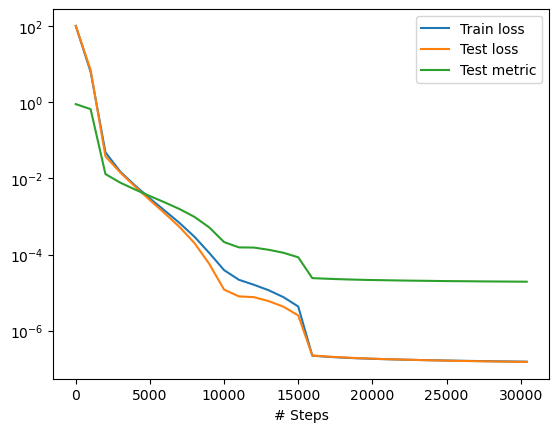

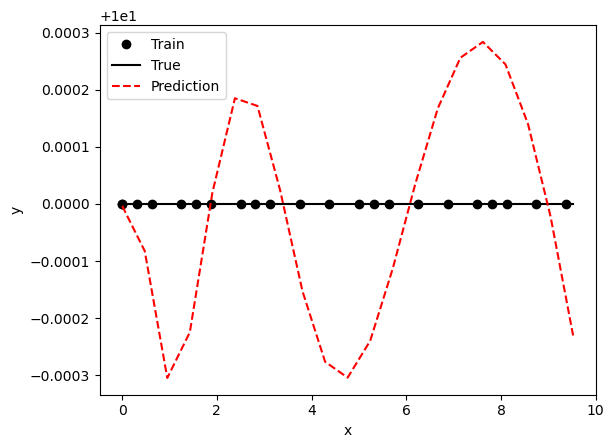

In [66]:

model.compile('L-BFGS', lr=learning_rate, metrics=["l2 relative error"])

losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, isplot=True, issave=False)


In [91]:
known_solution(0.1)

5.2497918747894